In [60]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
from gco import pygco

# 定义图像和参数文件的路径 # Define paths to image and parameter files
imgs_files = 'Road/Road/src'
para_files = 'Road/Road/cameras.txt'

# 通过列表推导式加载图像并转换为浮点型数组 # Load images through list comprehension and convert to floating point array
imgs = np.array([np.float32(cv.imread(os.path.join(imgs_files, filename))) for filename in os.listdir(imgs_files)])
print('images:', imgs.shape)

# 从文件中加载相机参数数据，跳过第一行 # Load camera parameter data from file, skip the first line
CamerasParameter = np.loadtxt('Road/Road/cameras.txt', dtype=np.float32, skiprows=1)

# 加载图像和相机参数 # Load image and camera parameters
K = []
R = []
T = []

# 将参数分割为K，R，T # Split the parameters into K, R, T
for i in range(0, 141):
    # 从参数数组中提取相机内参 K（3x3矩阵）# Extract camera internal parameters K (3x3 matrix) from the parameter array
    K.append(CamerasParameter[7 * i:7 * i + 3, :])
    # 从参数数组中提取相机旋转矩阵 R（3x3矩阵）# Extract the camera rotation matrix R (3x3 matrix) from the parameter array
    R.append(CamerasParameter[7 * i + 3:7 * i + 6, :])
    # 从参数数组中提取相机平移向量 T（3维向量）# Extract the camera translation vector T (3-dimensional vector) from the parameter array
    T.append(CamerasParameter[7 * i + 6, :])

# 转换为NumPy数组
K = np.array(K)
R = np.array(R)
T = np.array(T)

# 将 T 从 (141, 3) 变形为 (141, 1, 3)
T = T[:, np.newaxis, :]

# 输出数组形状信息 # Output array shape information
print('K', K.shape, 'R', R.shape, 'T', T.shape)

images: (141, 540, 960, 3)
K (141, 3, 3) R (141, 3, 3) T (141, 1, 3)


In [74]:
# Compute L2 norm between two images
def compare_img_norm2(i1, i2):
    return np.linalg.norm((i1 - i2), ord=2, axis=-1, keepdims=True)

# Generate homogeneous coordinates grid
def homo_coord_tran(height, width):
    x, y = np.float32(np.meshgrid(np.arange(width, dtype=np.float32), np.arange(height, dtype=np.float32), indexing='xy'))
    z = np.ones_like(x)  
    return np.stack([x, y, z], axis=0)

# Calculate 3D coordinates of the projected points
def GenerateCoordinates(K, R1, T1, R2, T2, coords_xy, disparity, height, width):  
    coords_xy = np.reshape(coords_xy, [3, -1])
    disparity = np.reshape(disparity, [1, -1])
    depth = (T1 - T2).T * disparity 
    remap = (K @ R2.T) @ ((R1 @ np.linalg.inv(K)) @ coords_xy + depth)
    remap = np.divide(remap, remap[2, :])
    remap = np.reshape(np.asarray(remap), [3, height, width])
    return remap

# Remap an image using coordinates
def My_remap(InputImage, thisMap):
    return cv.remap(src=InputImage, map1=thisMap, map2=None, interpolation=cv.INTER_NEAREST, borderValue=[128, 128, 128])

# Get depth map using graph cuts optimization
def GenerateDisparityMap(UnaryPotentialArray, para_smooth, height, width, lambda_factor=0.05):
    thisMap = pygco.cut_grid_graph_simple(UnaryPotentialArray, para_smooth * lambda_factor, connect=4, n_iter=-1)
    thisMap = thisMap.reshape(height, width)
    return thisMap

# Generate pairwise matrix
def GeneratePareWiseMatrix(SizeofLayers, threshold):
    indices = np.arange(SizeofLayers)
    diff = np.abs(indices[:, None] - indices)
    np.fill_diagonal(diff, 0)
    PareWiseMatrix = np.minimum(diff, threshold)
    return PareWiseMatrix

# Draw depth map
def draw_figure(depthmap, cur):
    plt.figure
    plt.imshow(depthmap, cmap='gray')
    plt.title('loop {}'.format(cur))
    plt.axis("off")
    plt.show()

# Main function for depth map estimation
def my_main(imgs, target_frame, compared_frames, DisparityMatrix, num_DisparityMatrix, K, R, T, threshold, sigma_c): 
    target_img = imgs[target_frame]
    height, width, _ = target_img.shape
    Dataterm = np.zeros((height, width, num_DisparityMatrix))
    num_frame = compared_frames
    homo_coords_traned = homo_coord_tran(height, width) 
    # print('homo_coords_traned', homo_coords_traned)
    disparity = np.zeros([height, width], dtype=np.float32) 
    # print('disparity', disparity)
    P_c_d = np.zeros([num_DisparityMatrix, height, width], dtype=np.float32)
    # print('disparity', disparity)
    DepthMaps = np.zeros([num_frame, height, width])
    # print('disparity', disparity)
    
    for i in range(compared_frames):
        main_index = target_frame + i + 1
        img_right = imgs[main_index]
        
        # Unary initialization
        for d_number in range(num_DisparityMatrix):
            disparity[:, :] = DisparityMatrix[d_number]
            x_prime_h = GenerateCoordinates(K[target_frame], R[target_frame], T[target_frame], R[main_index], T[main_index], homo_coords_traned, disparity, height, width)
            x_prime = np.transpose(x_prime_h[:2, :, :], [1, 2, 0])
            cur_img = My_remap(img_right, x_prime)
            this_norm2_distance = compare_img_norm2(target_img, cur_img)
            P_c = sigma_c / (sigma_c + this_norm2_distance)
            P_c_d[d_number, :, :] += P_c[:, :, 0]
        
        # Unary normalization
        u = np.reciprocal(P_c_d.max(axis=0, keepdims=True))
        UnaryPotentialArray_temp = 1 - u * P_c_d
        UnaryPotentialArray = np.zeros((height, width, num_DisparityMatrix))
        for l in range(num_DisparityMatrix):
            UnaryPotentialArray[:, :, l] = UnaryPotentialArray_temp[l, :, :]
        
        # Generate pairwise matrix
        PairWiseMatrix = GeneratePareWiseMatrix(num_DisparityMatrix, threshold)
        
        # Compute depth map using graph cuts
        depthmap = GenerateDisparityMap(UnaryPotentialArray, PairWiseMatrix, height, width, lambda_factor=0.1)
        DepthMaps[i, :, :] = depthmap
        draw_figure(depthmap, i + 1)
        Dataterm += UnaryPotentialArray
    
    Dataterm /= compared_frames
    depthmap = GenerateDisparityMap(Dataterm, PairWiseMatrix, height, width, lambda_factor=0.1)
    plt.figure
    plt.imshow(depthmap, cmap='gray')
    plt.title('Final Result')
    plt.axis("off")
    plt.show()
    
        

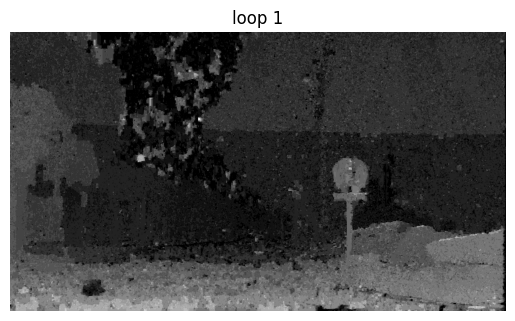

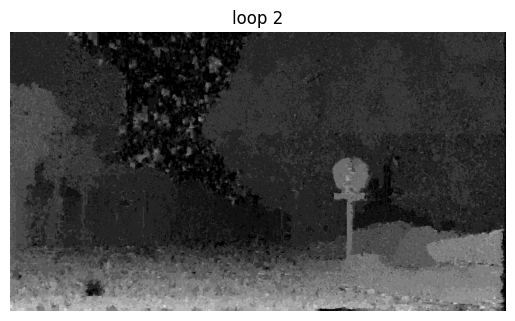

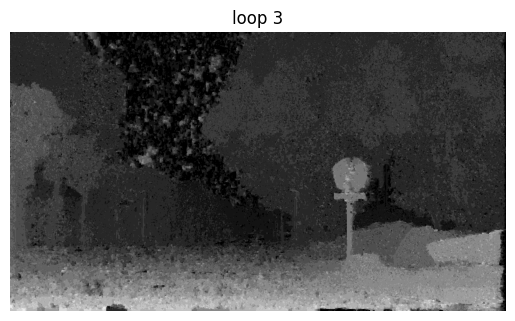

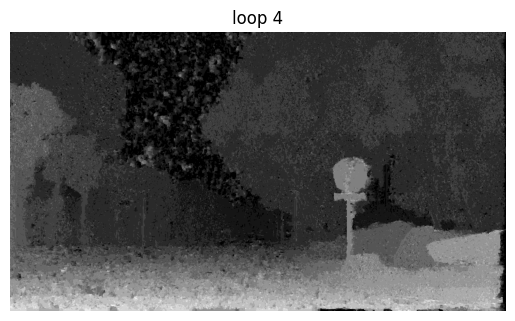

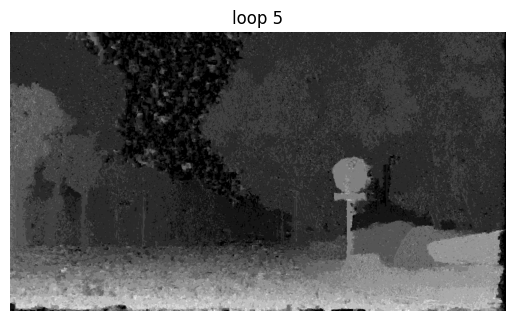

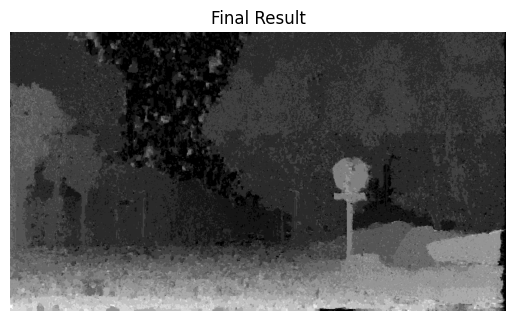

In [75]:
target_frame = 100
compared_frames = 5
dmin = 0.0
dmax = 0.05
SizeofLayers = 70
DisparityMatrix = np.linspace(dmin,dmax,SizeofLayers)
sigma_c=1
num_DisparityMatrix = len(DisparityMatrix)
threshold=20
my_main(imgs, target_frame, compared_frames, DisparityMatrix, num_DisparityMatrix,K, R, T, threshold, sigma_c)